In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import gym

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical

import random
from collections import deque

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class SimplePolicy(nn.Module):
    def __init__(self, s_size=4, h_size=16, a_size=2):
      #raise NotImplementedError
      super(SimplePolicy, self).__init__()
      self.fc1 = nn.Linear(s_size, h_size)
      self.output = nn.Linear(h_size, a_size)

      self.optimizer = torch.optim.Adam(self.parameters(), lr=0.001)

    def forward(self, x):
      x = self.fc1(x)
      x = F.relu(x)
      action_scores = self.output(x)
      x = F.softmax(action_scores, dim=0)
      return x




In [ ]:
def moving_average(a, n):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret / n




In [ ]:
def compute_returns(rewards, gamma):
    #raise NotImplementedError
    #rewards = array of rewards
    #gamma = discount factor

    returns = 0

    for i_reward in range(len(rewards)):
        returns += (gamma**i_reward)*(rewards[i_reward])
        
    return returns




In [ ]:
def reinforce(env, policy_model, seed, learning_rate,
              number_episodes,
              max_episode_length,
              gamma, verbose=True):
    # set random seeds (for reproducibility)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)

    env.seed(seed)

    scores = []

    #for each episode
    for i_episode in range(number_episodes):
        #print("Episode #: {}".format(i_episode))
        ep_reward = []
        current_state = env.reset()
        i_episode_length = 0
        log_probs = []

        for i_episode_length in range(max_episode_length):

            #choose actions by running policy model and choosing based on the probabilities
            state = torch.from_numpy(current_state).type(torch.FloatTensor)
            action_probabilities = policy_model(state)
            m = Categorical(action_probabilities)
            action = m.sample()
            log_probs.append(m.log_prob(action))
            #print(action.item())


            #Gather samples
            next_state, reward, done, info = env.step(action.item())
            ep_reward.append(reward)
            current_state = next_state

            if done:
                break

        
        #find returns
        returns = compute_returns(ep_reward, gamma)

        scores.append(returns)
        
        #Compute gradients
        policy_model.optimizer.zero_grad()

        #Gradient Ascent
        loss = -1 * (returns*np.sum(np.array((log_probs))))
        #print("Loss: {}".format(loss))

        #if i_episode == 0:
          #loss.backward(retain_graph=True)
        #else:
        loss.backward()
        # update policy parameters
        policy_model.optimizer.step()
        

    #raise NotImplementedError

    return policy_model, scores




In [ ]:
def run_reinforce():
    env = gym.make('CartPole-v1')
    policy_model = SimplePolicy(s_size=env.observation_space.shape[0], h_size=50, a_size=env.action_space.n)
    #print("Policy Model")
    #print(policy_model)
    policy, scores = reinforce(env=env, policy_model=policy_model, seed=42, learning_rate=1e-2,
                               number_episodes= 1500,
                               max_episode_length= 1000,
                               gamma=1.0,
                              verbose=True)
    # Plot learning curve
    #comput moving avg
    moving_avg_scores = moving_average(a = scores, n = 50)
    plt.figure(figsize=(10,5))
    plt.plot(scores, label = "Scores")
    plt.plot(moving_avg_scores, label = "Moving Average, w = 50")
    plt.title("Q4 Reinforce Learning Cure")
    plt.xlabel("Episode Number")
    plt.ylabel("Score")
    plt.legend()    
    #plt.savefig('Q4 REINFORCE_LEARNING')



Episode #: 0
Episode #: 1
Episode #: 2
Episode #: 3
Episode #: 4
Episode #: 5
Episode #: 6
Episode #: 7
Episode #: 8
Episode #: 9
Episode #: 10
Episode #: 11
Episode #: 12
Episode #: 13
Episode #: 14
Episode #: 15
Episode #: 16
Episode #: 17
Episode #: 18
Episode #: 19
Episode #: 20
Episode #: 21
Episode #: 22
Episode #: 23
Episode #: 24
Episode #: 25
Episode #: 26
Episode #: 27
Episode #: 28
Episode #: 29
Episode #: 30
Episode #: 31
Episode #: 32
Episode #: 33
Episode #: 34
Episode #: 35
Episode #: 36
Episode #: 37
Episode #: 38
Episode #: 39
Episode #: 40
Episode #: 41
Episode #: 42
Episode #: 43
Episode #: 44
Episode #: 45
Episode #: 46
Episode #: 47
Episode #: 48
Episode #: 49
Episode #: 50
Episode #: 51
Episode #: 52
Episode #: 53
Episode #: 54
Episode #: 55
Episode #: 56
Episode #: 57
Episode #: 58
Episode #: 59
Episode #: 60
Episode #: 61
Episode #: 62
Episode #: 63
Episode #: 64
Episode #: 65
Episode #: 66
Episode #: 67
Episode #: 68
Episode #: 69
Episode #: 70
Episode #: 71
Ep

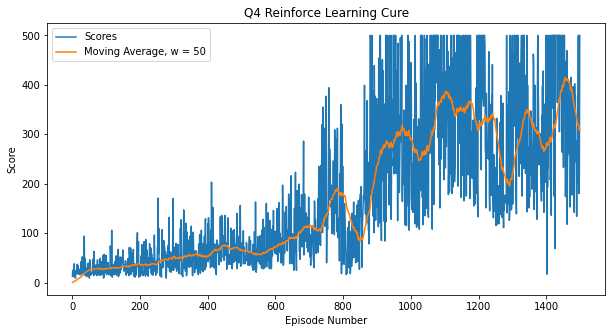

In [ ]:
run_reinforce()

In [ ]:
def investigate_variance_in_reinforce():
    env = gym.make('CartPole-v1')
    seeds = np.random.randint(1000, size=5)
    print(seeds)
    print(type(seeds[0]))
    tot_scores = []
    policy_model = SimplePolicy(s_size=env.observation_space.shape[0], h_size=50, a_size=env.action_space.n)
    for i_seed in range(seeds.shape[0]):
      print("Seed no: {}".format(i_seed))
      policy, scores = reinforce(env=env, policy_model=policy_model, seed=int(seeds[i_seed]), learning_rate=1e-2,
                               number_episodes= 2000,
                               max_episode_length= 1000,
                               gamma=1.0,
                              verbose=True)
      tot_scores.append(scores)
    
    tot_scores = np.asarray(tot_scores)
    #print("")
    #print("stats")
    #print(tot_scores.shape)
    #print(len(tot_scores[0]))
    mean = np.mean(tot_scores, axis =0)
    std = np.std(tot_scores,axis =0)
    return mean, std


In [ ]:
mean, std = investigate_variance_in_reinforce()

[170 440 789 498  77]
<class 'numpy.int64'>
Seed no: 0
Seed no: 1
Seed no: 2
Seed no: 3
Seed no: 4


Text(0.5, 1.0, 'Q5 Reinforce averaged over 5 seeds')

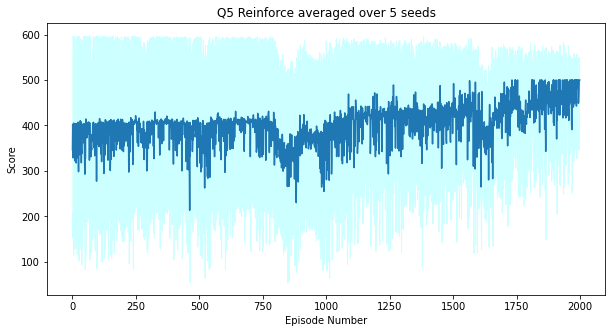

In [ ]:
x = np.arange(0,2000,1)
upperbound = mean+std
lowerbound = mean-std
plt.figure(figsize = (10,5))
plt.plot(mean)
plt.fill_between(x,upperbound,lowerbound, color = (0.8,1.0,1.0))
plt.xlabel("Episode Number")
plt.ylabel("Score")
plt.title("Q5 Reinforce averaged over 5 seeds")

In [ ]:
def compute_returns_naive_baseline(rewards, gamma):
  R = 0
  returns = []

  for i_reward in rewards[::-1]:
    R = i_reward + gamma*R
    returns.insert(0,R)
  
  returns =  torch.FloatTensor(returns)
  returns = (returns - returns.mean()) / (returns.std() + np.finfo(np.float32).eps)

  return returns

In [ ]:
def reinforce_naive_baseline(env, policy_model, seed, learning_rate,
                             number_episodes,
                             max_episode_length,
                             gamma, verbose=True):
    # set random seeds (for reproducibility)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    env.seed(seed)

    scores = []

    #for each episode
    for i_episode in range(number_episodes):
        #print("Episode #: {}".format(i_episode))
        ep_reward = []
        current_state = env.reset()
        i_episode_length = 0
        log_prob = []

        for i_episode_length in range(max_episode_length):

            #choose actions by running policy model and choosing based on the probabilities
            state = torch.from_numpy(current_state).type(torch.FloatTensor)
            action_probabilities = policy_model(state)
            m = Categorical(action_probabilities)
            action = m.sample()
            log_prob.append(m.log_prob(action).unsqueeze(0))
            #print(action.item())
            #print(type(log_probs[0]))


            #Gather samples
            next_state, reward, done, info = env.step(action.item())
            ep_reward.append(reward)
            current_state = next_state

            if done:
                break

        scores.append(sum(ep_reward))

        #find returns
        returns = compute_returns_naive_baseline(ep_reward, gamma)
        #print(returns)
        #Compute gradients
        
        #print(log_prob)
        log_prob = torch.cat(log_prob)
            
        #Gradient Ascent
        loss = -1 * torch.sum(log_prob*returns)
        #print("Loss: {}".format(loss))
        policy_model.optimizer.zero_grad()
        loss.backward()
        # update policy parameters
        policy_model.optimizer.step()
        

    #raise NotImplementedError

    return policy_model, scores


In [ ]:
def run_reinforce_with_naive_baseline():
    env = gym.make('CartPole-v1')

    np.random.seed(53)
    seeds = np.random.randint(1000, size=5)

    tot_scores = []
    policy_model = SimplePolicy(s_size=env.observation_space.shape[0], h_size=50, a_size=env.action_space.n)
    for i_seed in range(seeds.shape[0]):
      print("Seed no: {}".format(i_seed))
      policy, scores = reinforce_naive_baseline(env=env, policy_model=policy_model, seed=int(seeds[i_seed]), learning_rate=1e-2,
                               number_episodes= 2000,
                               max_episode_length= 1000,
                               gamma=1.0,
                              verbose=True)
      tot_scores.append(scores)
    
    tot_scores = np.asarray(tot_scores)
    #print("")
    #print("stats")
    #print(tot_scores.shape)
    #print(len(tot_scores[0]))
    mean = np.mean(tot_scores, axis =0)
    std = np.std(tot_scores,axis =0)
    return mean, std


    

In [ ]:
mean_naive, std_naive = run_reinforce_with_naive_baseline()

Seed no: 0
Seed no: 1
Seed no: 2
Seed no: 3
Seed no: 4


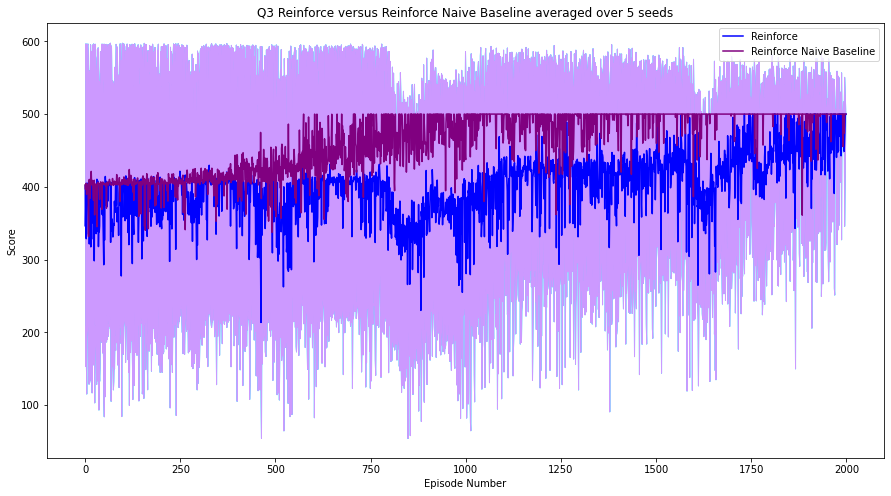

In [ ]:
x = np.arange(0,2000,1)
upperbound = mean+std
lowerbound = mean-std
upperbound_naive = mean+std
lowerbound_naive = mean-std
plt.figure(figsize = (15,8))
plt.plot(mean, color = (0,0,1), label = "Reinforce")
plt.plot(mean_naive, color = (0.5,0,0.5), label = "Reinforce Naive Baseline")
plt.fill_between(x,upperbound,lowerbound, color = (0.0,1.0,1.0))
plt.fill_between(x,upperbound_naive,lowerbound_naive, color = (0.8,0.6,1.0))
plt.xlabel("Episode Number")
plt.ylabel("Score")
plt.title("Q3 Reinforce versus Reinforce Naive Baseline averaged over 5 seeds")
plt.legend()

Question 3: Actor Critic

3.1. 

Actor-Critic Algorithm

The actor-critic algorithm allows us to learn both the parameterised policy as well as the value function. The critic in the system estimates the value function. This could be the action-value (the Q-value) or the state-value (The V value). The actor in the system updates the policy in the direction suggested by the critic. Simply put the actor decides which action to take, for a given state, and the critic tells the actor how good its action was and how it should adjust. Both the actor and critic can be neural networks. The input to the actor is a state and its output is an action. The input to the critic is the environment as well as the action taken by the actor, and its output is the action-value for the given pair. Training of the 2 neural networks is done seperately. The weights of each network is updated using gradient ascent. Updates of the weights happen at each step rather than at the end of an episode.

Actor-Critic Network Architecture

The actor-critic architecture is composed of 2 seperate neural networks.

Actor Network Architecture:
Hidden Layers: 2
Activation Functions: relu, tanh

Critic Network Architecture:
Hiddenn Layers: 2
Activation Fuctions: relu
 
https://github.com/shivaverma/OpenAIGym/blob/master/lunar-lander/continuous/actor.py
